In [2]:
import os
import random
import sys
import time


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow
py.init_notebook_mode(connected=True)


## Keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

In [14]:
dir_list = os.listdir("/kaggle/input/voice-stress-analysis-dataset/audio_speech_actors_01-24")
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [18]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir("/kaggle/input/voice-stress-analysis-dataset/audio_speech_actors_01-24/" + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = "/kaggle/input/voice-stress-analysis-dataset/audio_speech_actors_01-24/" + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [19]:
print (len(data_df))
data_df.head(25)

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,0,1,1,2
1,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,0,0,1,1
2,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,1,0,1,4
3,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,1,1,0,2
4,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,0,1,0,2
5,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,0,1,1,6
6,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,1,0,1,3
7,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,0,1,0,3
8,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,1,0,1,7
9,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,0,0,1,5


In [20]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

/kaggle/input/voice-stress-analysis-dataset/audio_speech_actors_01-24/Actor_18/03-01-04-02-02-01-18.wav


(22050,
 array([-3.0419525e-07,  2.7847739e-07, -2.1521136e-07, ...,
         3.0705354e-07, -5.2770346e-08,  0.0000000e+00], dtype=float32))

In [21]:
len(samples), sample_rate

(91232, 22050)

In [22]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [23]:
sample_rate/ len(samples)

0.24169151175026307

Text(0.5, 0, 'Seconds')

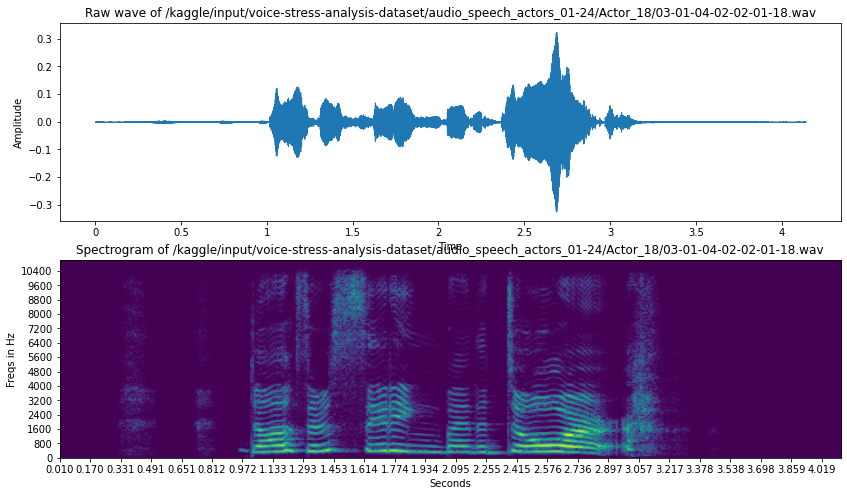

In [24]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveshow(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [25]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [26]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([ 0.00079012,  0.0007941 ,  0.0008014 , ..., -0.00268472,
        -0.00179682, -0.00045763], dtype=float32),
 array([22016, 69632]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Pass y=[ 0.00079012  0.0007941   0.0008014  ... -0.00268472 -0.00179682
 -0.00045763] as keyword args. From version 0.10 passing these as positional arguments will result in an error



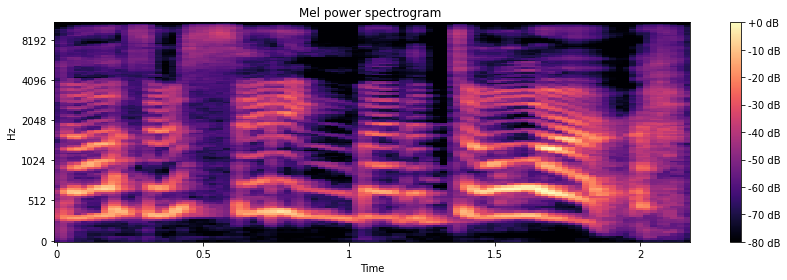

In [27]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

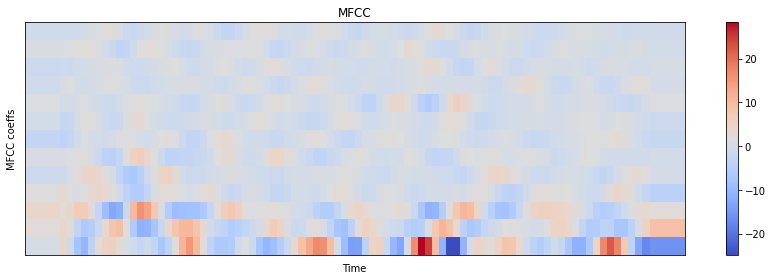

In [28]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [29]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [30]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [31]:
# Silence trimmed Sound by manual trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

In [32]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "neutral"
    elif data_df.emotion[i] == 2:
        lb = "positive"
    elif data_df.emotion[i] == 3:
        lb = "positive"
    elif data_df.emotion[i] == 4:
        lb = "negative"
    elif data_df.emotion[i] == 5:
        lb = "negative"
    elif data_df.emotion[i] == 6:
        lb = "negative"
    elif data_df.emotion[i] == 7:
        lb = "neutral"
    elif data_df.emotion[i] == 8:
        lb = "neutral"
    else:
        lb = "neutral"
        
    # Add gender to the label 
    label8_list.append(lb)
    
len(label8_list)

1440

In [33]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label8_list
# data_df['label'] = label3_list

data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data_df))):
    X, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]


# data_df['label'] = label5_list
#data_df['label'] = label8_list
data_df.head()

100%|██████████| 1440/1440 [02:59<00:00,  8.01it/s]


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,0,1,1,2,positive
1,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,0,0,1,1,neutral
2,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,1,0,1,4,negative
3,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,1,1,0,2,positive
4,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,0,1,0,2,positive


In [34]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

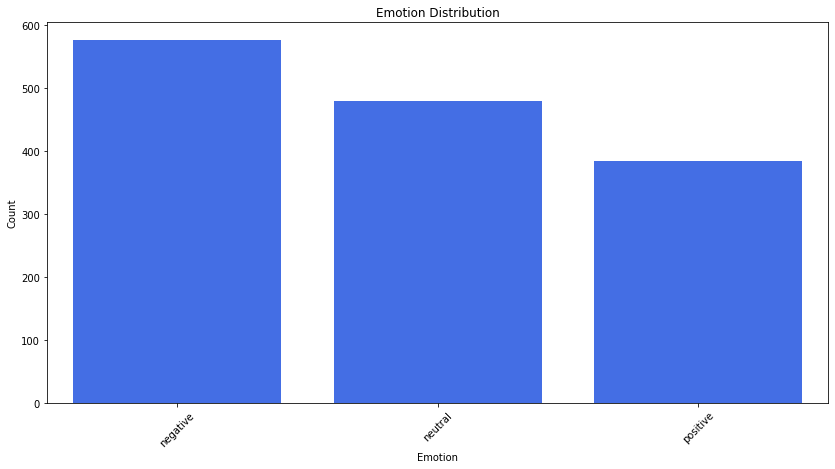

In [35]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [36]:
data_df["label"].value_counts()

negative    576
neutral     480
positive    384
Name: label, dtype: int64

In [37]:
neutral_data=data_df[data_df["label"]=="neutral"]
positive_data=data_df[data_df["label"]=="positive"]
negative_data=data_df[data_df["label"]=="negative"]

In [38]:
positive_data.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,0,1,1,2,positive
3,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,1,1,0,2,positive
4,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,0,1,0,2,positive
6,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,1,0,1,3,positive
7,/kaggle/input/voice-stress-analysis-dataset/au...,1,1,male,0,1,0,3,positive


In [39]:
neutral_data=neutral_data.sample(n = 380)
positive_data=positive_data.sample(n = 380)
negative_data=negative_data.sample(n = 380)

In [40]:
len(negative_data)

380

In [41]:
data_df=pd.concat([neutral_data,positive_data,negative_data], axis=0)

In [42]:
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
725,/kaggle/input/voice-stress-analysis-dataset/au...,1,13,male,0,0,0,1,neutral
408,/kaggle/input/voice-stress-analysis-dataset/au...,1,7,male,1,1,0,7,neutral
1303,/kaggle/input/voice-stress-analysis-dataset/au...,1,22,female,0,0,1,8,neutral
1180,/kaggle/input/voice-stress-analysis-dataset/au...,1,20,female,1,1,0,7,neutral
97,/kaggle/input/voice-stress-analysis-dataset/au...,1,2,female,1,1,1,7,neutral


In [43]:
data_df.label.value_counts()

neutral     380
positive    380
negative    380
Name: label, dtype: int64

In [44]:
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
725,/kaggle/input/voice-stress-analysis-dataset/au...,1,13,male,0,0,0,1,neutral
408,/kaggle/input/voice-stress-analysis-dataset/au...,1,7,male,1,1,0,7,neutral
1303,/kaggle/input/voice-stress-analysis-dataset/au...,1,22,female,0,0,1,8,neutral
1180,/kaggle/input/voice-stress-analysis-dataset/au...,1,20,female,1,1,0,7,neutral
97,/kaggle/input/voice-stress-analysis-dataset/au...,1,2,female,1,1,1,7,neutral


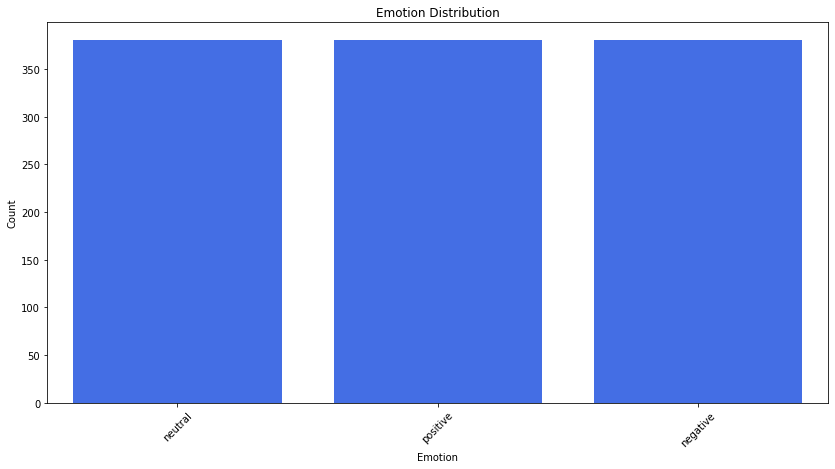

In [45]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [46]:
data_df=data_df.reset_index(drop=True)

In [47]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data_df))):
    X, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]



100%|██████████| 1140/1140 [02:13<00:00,  8.56it/s]


In [48]:
data.head()

,feature
0,"[-67.69534, -67.69534, -67.69534, -66.01462, -..."
1,"[-51.24556, -51.787357, -52.35346, -52.554356,..."
2,"[-57.777523, -57.45294, -57.777523, -57.777523..."
3,"[-53.08654, -52.829105, -52.4345, -52.386856, ..."
4,"[-58.344402, -58.344402, -58.407536, -58.51291..."


In [49]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data_df.label

In [50]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-67.695343,-67.695343,-67.695343,-66.014618,-64.587608,-67.108429,-64.659927,-61.150780,-60.629314,-61.321812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-51.245560,-51.787357,-52.353458,-52.554356,-52.513279,-53.273979,-55.973701,-54.183914,-49.616379,-47.329647,...,-51.204140,-50.987453,-50.532757,-51.570694,-52.998455,-52.276363,-52.246864,-48.604630,-44.706242,-43.775192
2,-57.777523,-57.452942,-57.777523,-57.777523,-57.777523,-56.756832,-55.584938,-55.250931,-53.938961,-53.423801,...,-57.110474,-57.777523,-56.679695,-54.888176,-55.919655,-57.777523,-57.777523,-57.467899,-56.794964,-56.488472
3,-53.086540,-52.829105,-52.434502,-52.386856,-52.716995,-53.086540,-53.086540,-53.086540,-53.067326,-53.086540,...,-46.890396,-47.010368,-45.926018,-45.174778,-43.614815,-43.882954,-43.148151,-42.519035,-32.038250,-25.592815
4,-58.344402,-58.344402,-58.407536,-58.512917,-58.879910,-58.806641,-57.803219,-56.976448,-53.500244,-53.100174,...,-51.851650,-53.108688,-55.580463,-53.420162,-54.129822,-55.077316,-52.524967,-50.238289,-51.224583,-53.092957


In [51]:
newdf = pd.concat([df3,labels], axis=1)

In [52]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

1140

In [53]:
rnewdf.isnull().sum().sum()

4411

In [54]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-67.695343,-67.695343,-67.695343,-66.014618,-64.587608,-67.108429,-64.659927,-61.150780,-60.629314,-61.321812,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
1,-51.245560,-51.787357,-52.353458,-52.554356,-52.513279,-53.273979,-55.973701,-54.183914,-49.616379,-47.329647,...,-50.987453,-50.532757,-51.570694,-52.998455,-52.276363,-52.246864,-48.604630,-44.706242,-43.775192,neutral
2,-57.777523,-57.452942,-57.777523,-57.777523,-57.777523,-56.756832,-55.584938,-55.250931,-53.938961,-53.423801,...,-57.777523,-56.679695,-54.888176,-55.919655,-57.777523,-57.777523,-57.467899,-56.794964,-56.488472,neutral
3,-53.086540,-52.829105,-52.434502,-52.386856,-52.716995,-53.086540,-53.086540,-53.086540,-53.067326,-53.086540,...,-47.010368,-45.926018,-45.174778,-43.614815,-43.882954,-43.148151,-42.519035,-32.038250,-25.592815,neutral
4,-58.344402,-58.344402,-58.407536,-58.512917,-58.879910,-58.806641,-57.803219,-56.976448,-53.500244,-53.100174,...,-53.108688,-55.580463,-53.420162,-54.129822,-55.077316,-52.524967,-50.238289,-51.224583,-53.092957,neutral


In [55]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

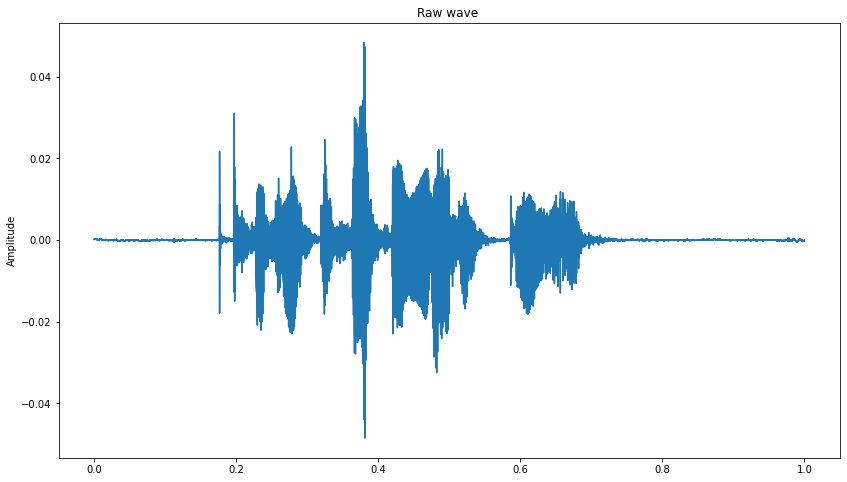

In [56]:
X, sample_rate = librosa.load(data_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.3)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error



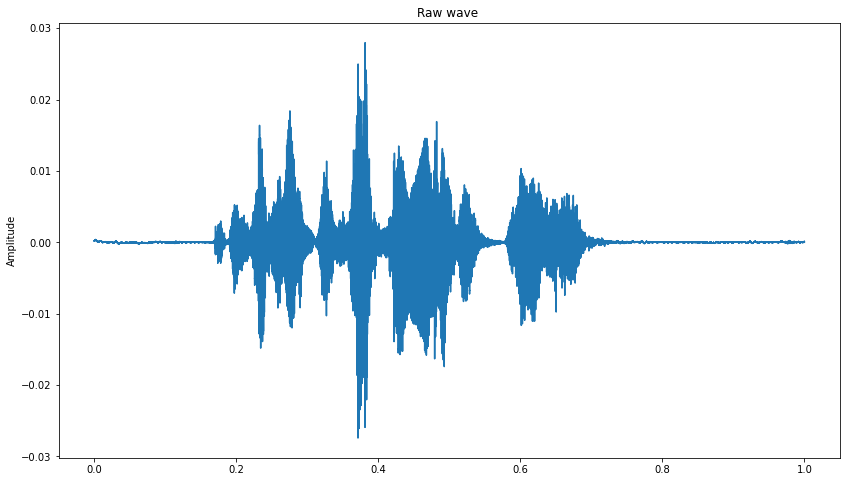

In [57]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [58]:
# Data Making Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data_df))):
    X, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data_df.label[i]]

100%|██████████| 1140/1140 [02:25<00:00,  7.82it/s]


In [59]:
# Data Making Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data_df))):
    X, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data_df.label[i]]

  0%|          | 0/1140 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

  4%|▎         | 40/1140 [00:16<08:33,  2.14it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

100%|██████████| 1140/1140 [07:49<00:00,  2.43it/s]


In [60]:
len(syn_data1), len(syn_data2)

(1140, 1140)

In [61]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [62]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

1140

In [63]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-54.502928,-51.837626,-49.165724,-49.226051,-50.139245,-52.388112,-51.129572,-48.493050,-50.504871,-53.231515,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
1,-41.332662,-39.992736,-38.493113,-39.187099,-40.543971,-41.922384,-42.120845,-42.793249,-43.322255,-39.996520,...,-39.936263,-40.650556,-40.972892,-41.278437,-42.264534,-42.403778,-40.302109,-37.860162,-38.823773,neutral
2,-48.482796,-45.707306,-44.797394,-44.704686,-45.038846,-45.557789,-43.992365,-43.230415,-44.102252,-42.268339,...,-43.875825,-45.289092,-43.693142,-43.431441,-45.039777,-44.632669,-44.901150,-45.236801,-44.496009,neutral
3,-47.998558,-45.803436,-47.312143,-47.391944,-47.116341,-45.320289,-45.029177,-46.169190,-47.286715,-46.700355,...,-41.924955,-41.053293,-41.092791,-39.465377,-40.654903,-40.429654,-39.449691,-31.756210,-25.397361,neutral
4,-43.926975,-43.129539,-44.066447,-45.893497,-48.159399,-45.257015,-43.851040,-44.555468,-44.215702,-43.106012,...,-44.188870,-43.930268,-44.039774,-45.554321,-44.778331,-44.573346,-45.200135,-45.839852,-46.697501,neutral


In [64]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

1140

In [65]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-66.898271,-66.898271,-66.898271,-66.898271,-66.898271,-66.898271,-66.516719,-66.457200,-63.614931,-62.192355,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
1,-51.601805,-52.563124,-54.564208,-55.768985,-55.949242,-57.444367,-58.448223,-54.509769,-51.390328,-51.215198,...,-56.213492,-56.051942,-56.435290,-57.742787,-54.985235,-52.265701,-51.769756,-52.184571,-53.991275,neutral
2,-59.853746,-58.919715,-59.719532,-59.853746,-59.691235,-58.118726,-57.022079,-57.010166,-55.963853,-55.034035,...,-59.308740,-59.105265,-58.617333,-57.711640,-59.280020,-59.853746,-59.853746,-59.796199,-59.017170,neutral
3,-54.795987,-54.787954,-54.515999,-54.231619,-54.258824,-54.638402,-54.795987,-54.795987,-54.795987,-54.795987,...,-50.206850,-49.156275,-47.946818,-47.385959,-46.079789,-45.315854,-37.712076,-32.865967,-32.288840,neutral
4,-60.507373,-60.507373,-60.483984,-60.163889,-59.501326,-58.989296,-59.101199,-57.679700,-55.912275,-55.595262,...,-58.081004,-58.788502,-59.133941,-59.758912,-60.477624,-59.984211,-58.742787,-58.286371,-58.693770,neutral


In [66]:
# Combining the Proccessed data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-67.695343,-67.695343,-67.695343,-66.014618,-64.587608,-67.108429,-64.659927,-61.150780,-60.629314,-61.321812,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
1,-51.245560,-51.787357,-52.353458,-52.554356,-52.513279,-53.273979,-55.973701,-54.183914,-49.616379,-47.329647,...,-50.987453,-50.532757,-51.570694,-52.998455,-52.276363,-52.246864,-48.604630,-44.706242,-43.775192,neutral
2,-57.777523,-57.452942,-57.777523,-57.777523,-57.777523,-56.756832,-55.584938,-55.250931,-53.938961,-53.423801,...,-57.777523,-56.679695,-54.888176,-55.919655,-57.777523,-57.777523,-57.467899,-56.794964,-56.488472,neutral
3,-53.086540,-52.829105,-52.434502,-52.386856,-52.716995,-53.086540,-53.086540,-53.086540,-53.067326,-53.086540,...,-47.010368,-45.926018,-45.174778,-43.614815,-43.882954,-43.148151,-42.519035,-32.038250,-25.592815,neutral
4,-58.344402,-58.344402,-58.407536,-58.512917,-58.879910,-58.806641,-57.803219,-56.976448,-53.500244,-53.100174,...,-53.108688,-55.580463,-53.420162,-54.129822,-55.077316,-52.524967,-50.238289,-51.224583,-53.092957,neutral


In [67]:
#  Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [68]:
y_train.value_counts()

positive    912
negative    912
neutral     912
Name: label, dtype: int64

In [69]:
y_test.value_counts()

neutral     228
positive    228
negative    228
Name: label, dtype: int64

In [70]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

import pickle
pickle.dump(lb, open("lb.sav", 'wb'))

In [71]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [72]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [73]:
X_train.shape

(2736, 259)

In [74]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='valid',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(3))
model.add(Activation('softmax'))
#opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 252, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 252, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 252, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 252, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 252, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 252, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 31, 256)           0

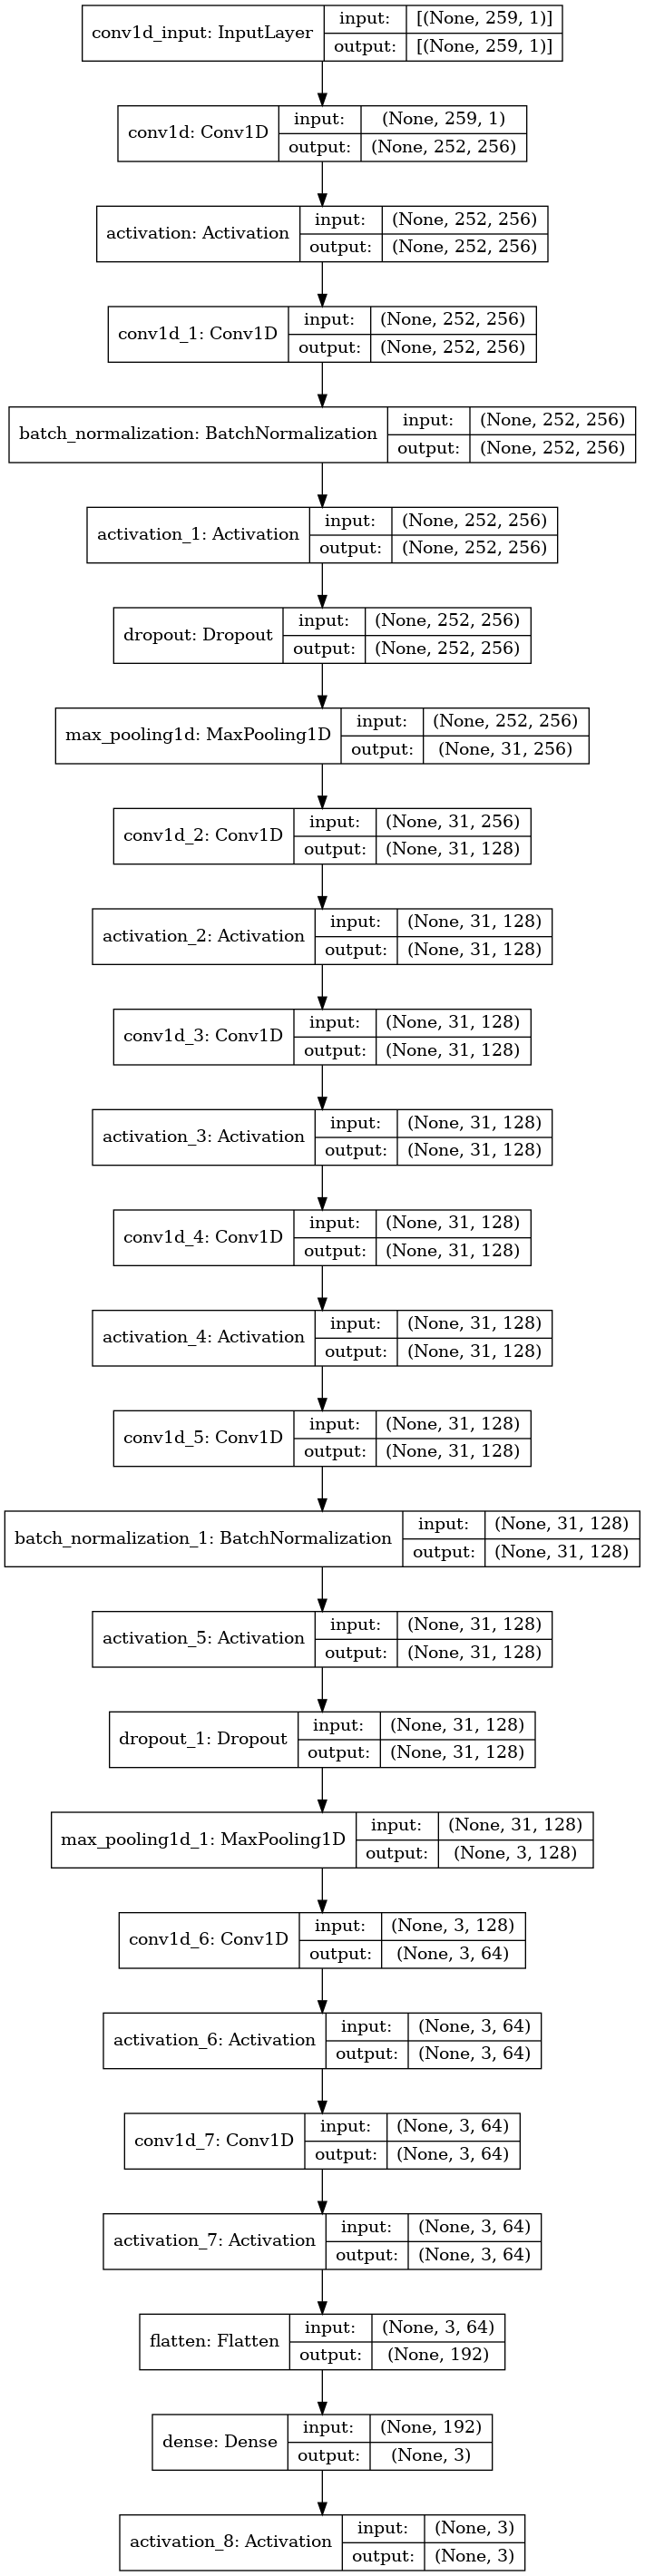

In [76]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='demo.png',show_shapes=True)

In [78]:
# Compile your model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('Data_noiseNshift.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=100,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/100
171/171 [==============================] - 33s 190ms/step - loss: 0.5874 - accuracy: 0.7442 - val_loss: 0.9328 - val_accuracy: 0.5760
Epoch 2/100
171/171 [==============================] - 32s 189ms/step - loss: 0.5642 - accuracy: 0.7518 - val_loss: 0.9146 - val_accuracy: 0.5789
Epoch 3/100
171/171 [==============================] - 33s 192ms/step - loss: 0.5737 - accuracy: 0.7518 - val_loss: 0.9351 - val_accuracy: 0.5585
Epoch 4/100
171/171 [==============================] - 33s 192ms/step - loss: 0.5089 - accuracy: 0.7869 - val_loss: 1.1559 - val_accuracy: 0.5351
Epoch 5/100
171/171 [==============================] - 33s 194ms/step - loss: 0.5217 - accuracy: 0.7650 - val_loss: 0.8393 - val_accuracy: 0.6213
Epoch 6/100
171/171 [==============================] - 33s 190ms/step - loss: 0.4830 - accuracy: 0.7953 - val_loss: 1.1708 - val_accuracy: 0.5102
Epoch 7/100
171/171 [==============================] - 33s 192ms/step - loss: 0.4990 - accuracy: 0.7792 - val_loss: 1.0027 -

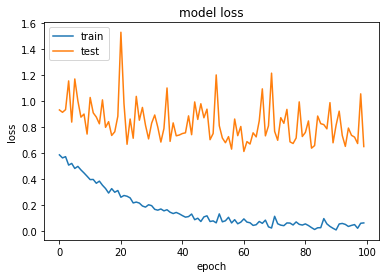

In [81]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [82]:
import json
model_json = model.to_json()
with open("voice_model.json", "w") as json_file:
    json_file.write(model_json)

    json_file.write(model_json)

In [83]:
start_time = time.perf_counter()
y_pred=model.predict(x_testcnn)
pred_category=np.array([])
for i in range(y_pred.shape[0]):
    pred_category=np.append(pred_category, [y_pred[i].argmax(axis=0)])
flat_category = pred_category.astype(int).flatten()
end_time=time.perf_counter()
execution_time = end_time - start_time
print(f"Total execution time is: {execution_time}, per record execution time: {execution_time/y_pred.shape[0]}")

Total execution time is: 2.246144163000281, per record execution time: 0.003283836495614446


In [84]:
y_test_category=np.array([])
for i in range(y_test.shape[0]):
    y_test_category=np.append(y_test_category, [y_test[i].argmax(axis=0)])
y_test_flat_category = y_test_category.astype(int).flatten()

In [85]:
print(classification_report(y_test_flat_category, flat_category, target_names=lb.inverse_transform([0,1,2])))

              precision    recall  f1-score   support

    negative       0.80      0.82      0.81       228
     neutral       0.82      0.76      0.79       228
    positive       0.80      0.84      0.82       228

    accuracy                           0.81       684
   macro avg       0.81      0.81      0.81       684
weighted avg       0.81      0.81      0.81       684



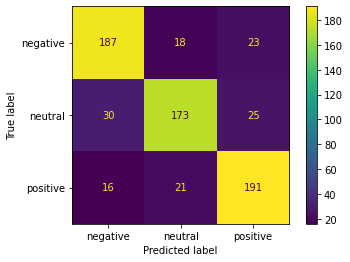

In [86]:
conf_mat=confusion_matrix(lb.inverse_transform(y_test_flat_category), lb.inverse_transform(flat_category), labels=lb.inverse_transform([0,1,2]))
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = lb.inverse_transform([0,1,2]))

cm_display.plot()
plt.show()

In [87]:
import tensorflow as tf
from tensorflow.keras.initializers import glorot_uniform
loaded_model = tf.keras.models.load_model("Data_noiseNshift.h5",custom_objects={'GlorotUniform': glorot_uniform()})
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 80.56%
